Zadanie 1.

In [1]:
import numpy as np
from numpy import linalg as LA

A = np.array([[1, 1], [1, 1.0001]])
b_1 = np.array([2, 2.0001])
b_2 = np.array([2, 2])

#x_11 = 1 x_21 = 1, x_21 = 2, x_22 = 0
#Rozwiązania uległy dużej zmianie mimo niewielkiej zmianie b

fro = LA.cond(A, p='fro')
print(fro)

40002.00010000441


Zadanie 2.

In [2]:
from scipy.linalg import hilbert

H = hilbert(8)

fro_cond = LA.cond(H, p='fro')
print(fro_cond)

nuc_cond = LA.cond(H, p=1)
print(nuc_cond)

inf_cond = LA.cond(H, p=np.inf)
print(inf_cond)

15493617168.394407
33872789110.107353
33872789109.75766


Zadanie 3.

In [3]:
from scipy.linalg import solve_triangular
import time

ITERATIONS = 100000

#Ustawianie układu równań
t = np.linspace(0, 1, 20)
b = np.array([np.cos(4*x) for x in t])
A = np.vander(t, increasing=True)

#Metoda solve
start = time.time()

for i in range(ITERATIONS):
    x_solve = LA.solve(A, b)
    r_solve = b - np.matmul(A, x_solve)

time_solve = time.time() - start
    
#Metoda QR
start = time.time()

for i in range(ITERATIONS):
    q, r = np.linalg.qr(A)
    y_qr = np.matmul(np.transpose(q), b)
    x_qr = solve_triangular(r, y_qr)
    r_qr = b - np.matmul(A, x_qr)
    
time_qr = time.time() - start    

#Metoda lstsq
stat = time.time()

for i in range(ITERATIONS):
    start = time.time()
    x_lstsq = LA.lstsq(A, b)[0]
    r_lstsq = b - np.matmul(A, x_lstsq)
    
time_lstsq = time.time() - start    

#Wypisyanie sumy błędów i czasów
print(sum(abs(r_qr)), time_qr) # najwolniejszy
print(sum(abs(r_solve)), time_solve) #najmniejszy błąd
print(sum(abs(r_lstsq)), time_lstsq) #największy błąd, najszybszy

/home/sebastian/Programs/anacond3/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


1.1352030426792226e-14 12.036853075027466
9.686695889854491e-15 2.0103626251220703
4.371503159461554e-14 0.00015044212341308594


Zadanie 4.

     name  tau_value  execution_time_100         error
0   solve       0.01            0.001594  7.771561e-16
1   solve       0.05            0.001463  7.771561e-16
2   solve       0.10            0.001540  7.771561e-16
3   solve       0.20            0.002131  2.761597e-01
4   solve       0.50            0.001573  6.916088e-01
5   solve       0.75            0.001447  9.552166e-01
6   gmres       0.01            0.025201  4.440892e-16
7   gmres       0.05            0.024121  4.440892e-16
8   gmres       0.10            0.024812  4.440892e-16
9   gmres       0.20            0.024242  2.761597e-01
10  gmres       0.50            0.024076  6.916088e-01
11  gmres       0.75            0.024064  9.552166e-01
12   bicg       0.01            0.061055  1.931788e-14
13   bicg       0.05            0.065647  1.931788e-14
14   bicg       0.10            0.048589  1.931788e-14
15   bicg       0.20            0.057630  2.761597e-01
16   bicg       0.50            0.048315  6.916088e-01
17   bicg 

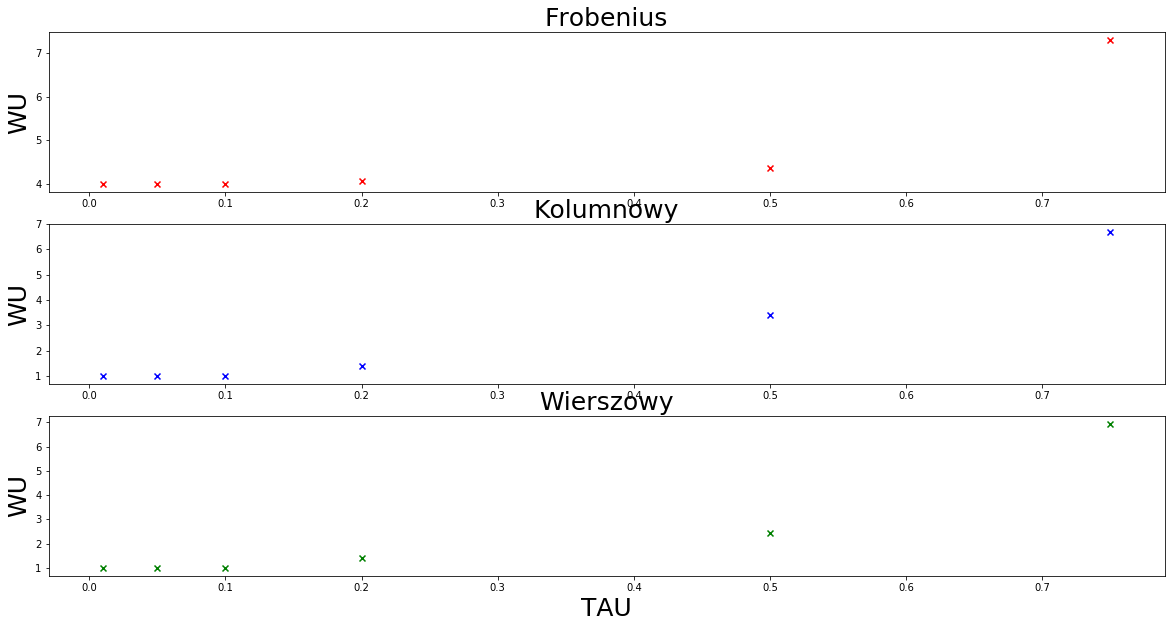

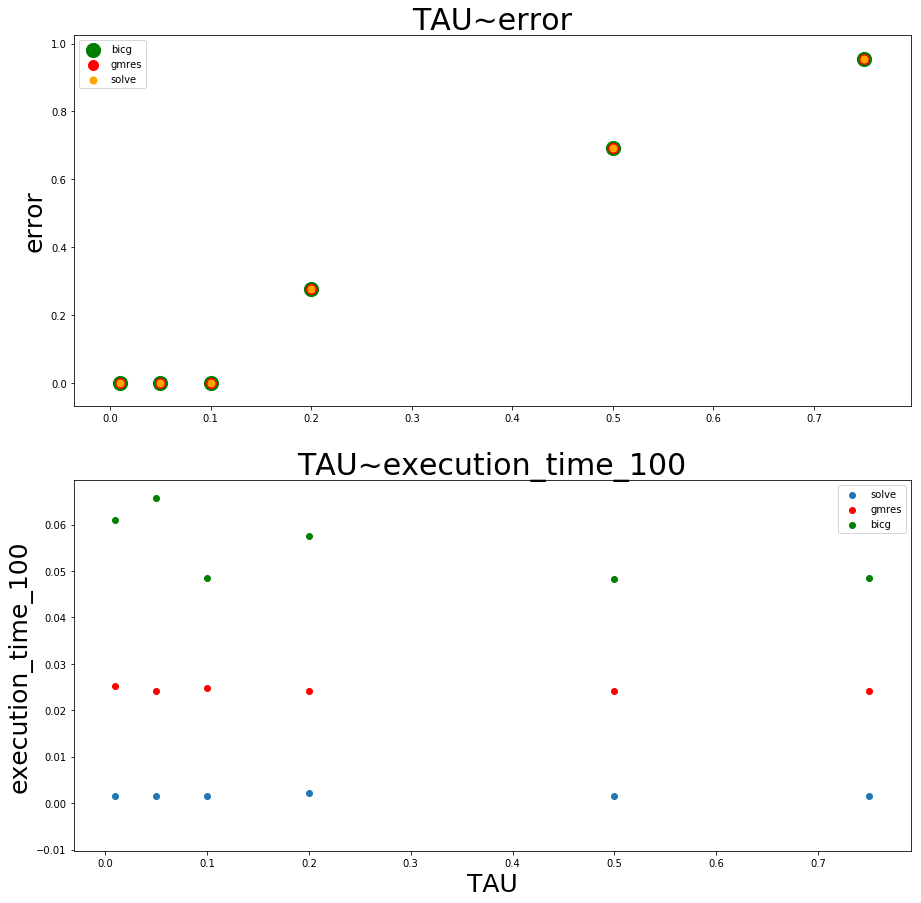

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import bicg

SIZE = 4
ITERATIONS = 100
TAU = [0.01, 0.05, 0.1, 0.2, 0.5, 0.75]
df_records = []
t_str = 'execution_time_' + str(ITERATIONS)


#Funkcja, która zwraca współczynnik uwarunkowania
def tau_matrix_cond(A, tau, pp):
    A = A * (abs(A) < tau)
    np.fill_diagonal(A, 1)
    return LA.cond(A, p=pp)


#Funkcja, która zwraca uwarunkowaną macierz
def tau_matrix(A, tau):
    A = A * (abs(A) > tau)
    np.fill_diagonal(A, 1)
    return A


#Funkcja zwracając listę z nazwą funckji, tau, czasem wykonania, i błędem
def get_funcs_stats(A, b, func, ITERATIONS):
    result = []
    for tau in TAU:
        if func == 'gmres' or func == 'bicg':
            
            """Nie wiem czy licząc czas brać pod uwagę również czas liczenie csr_matrix,
            liczenie go z każdym razem znacznie spowalnia proces"""
            
            csr = csr_matrix(tau_matrix(A, tau), dtype='float')
        start = time.time()
        for i in range(ITERATIONS):
            if func == 'solve':
                x = LA.solve(tau_matrix(A, tau), b)
            elif func == 'gmres':
                x, exit_code = gmres(csr, b) 
            elif func == 'bicg':
                x, exit_code = bicg(csr, b)
        time_ = time.time() - start
        r = sum(abs(b - np.matmul(A, x)))
        result.append([func, tau, time_, r])
    return result


#Stworzenie macierzy do obliczeń
values = np.random.uniform(-1,1,SIZE*SIZE)
A = np.reshape(values, (SIZE, SIZE))
np.fill_diagonal(A, 1)
b = np.random.uniform(-1, 1, SIZE)

#rysowanie wykresów współczynnika uwarunkowania od tau
fig, [ax1, ax2, ax3,] = plt.subplots(3, 1, figsize=(20, 10))

ax1.scatter(TAU, [tau_matrix_cond(A, tau, 'fro') for tau in TAU], color='red', marker='x')
ax1.set_title('Frobenius', fontsize=25)
ax1.set_ylabel('WU', fontsize=25)

ax2.scatter(TAU, [tau_matrix_cond(A, tau, np.inf) for tau in TAU], color='blue', marker='x')
ax2.set_title('Kolumnowy', fontsize=25)
ax2.set_ylabel('WU', fontsize=25)

ax3.scatter(TAU, [tau_matrix_cond(A, tau, 1) for tau in TAU], color='green', marker='x')
ax3.set_title('Wierszowy', fontsize=25)
ax3.set_xlabel('TAU', fontsize=25)
ax3.set_ylabel('WU', fontsize=25)

#tworzenie dataframe z statystykami
df_records = get_funcs_stats(A, b, 'solve', ITERATIONS)
df_records = df_records + get_funcs_stats(A, b, 'gmres', ITERATIONS)
df_records = df_records + get_funcs_stats(A, b, 'bicg', ITERATIONS)
    
stats = pd.DataFrame(df_records, columns=['name', 'tau_value', t_str, 'error'])

#rysowanie wykresów wielkości błędu, czasu od tau 
fig1, (ax4, ax5) = plt.subplots(2, 1, figsize=(15,15))

#ustawiłem różne zmienne s, żeby było widać, że wielkość błędu nie zależy od rodzaju użytej funkcji
ax4.scatter(TAU, stats[stats['name'] == 'gmres']['error'], color='green', s=200)
ax4.scatter(TAU, stats[stats['name'] == 'solve']['error'], color='red', s=100)
ax4.scatter(TAU, stats[stats['name'] == 'bicg']['error'], color='orange', s=50)
ax4.legend(['bicg', 'gmres', 'solve'])
ax4.set_title("TAU~error", fontsize=30)
ax4.set_ylabel("error", fontsize=25)


ax5.scatter(TAU, stats[stats['name'] == 'solve'][t_str])
ax5.scatter(TAU, stats[stats['name'] == 'gmres'][t_str], color='red')
ax5.scatter(TAU, stats[stats['name'] == 'bicg'][t_str], color='green')
ax5.legend(['solve', 'gmres', 'bicg'])
ax5.set_title("TAU~"+t_str, fontsize=30)
ax5.set_xlabel("TAU", fontsize=25)
ax5.set_ylabel(t_str, fontsize=25)

print(stats)

Zadanie 5.

In [6]:
def gauss_seidl(A, b, ITERATIONS=10000, epsilon=10**(-9)):
    
    L_inv = LA.inv(np.tril(A))
    x = np.ones(np.shape(b))
    T = -1 * np.matmul(L_inv, np.triu(A, 1))
    C = np.matmul(L_inv, b)
    i = 0
    r = sum(abs(b - np.matmul(A, x)))
    
    while i < ITERATIONS and r > epsilon:
        x = np.matmul(T, x) + C
        r = sum(abs(b - np.matmul(A, x)))
        i += 1
    
    return x


A_n = A
b_n = b

x_my = gauss_seidl(A, b)
x_solve = LA.solve(A, b)
print(sum(abs(x_my - x_solve)))

A_n = np.array([[1, 2, 3],
              [2, 1, 3],
              [3, 2, 1]])
b_n = np.array([1, 2, 0])

x = gauss_seidl(A_n, b_n)
x
#Średni ten wynik, macierz nie spełnia żadnego z warnuków wystarczających


5.147063331101265e-10


/home/sebastian/Programs/anacond3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


array([-1.74230664e+308,              inf,  1.17392592e+308])